# Method 8 - Best Fresh Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
# Backtest the Portfolio

w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

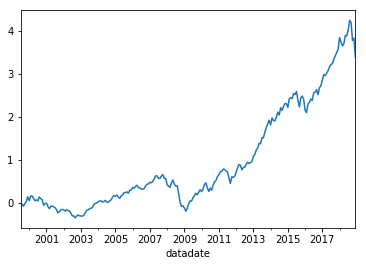

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.135397
2000-12-31   -0.141850
2001-12-31   -0.137641
2002-12-31   -0.180541
2003-12-31    0.439613
2004-12-31    0.172895
2005-12-31    0.109114
2006-12-31    0.113030
2007-12-31    0.084269
2008-12-31   -0.407249
2009-12-31    0.410102
2010-12-31    0.232161
2011-12-31    0.006949
2012-12-31    0.210331
2013-12-31    0.495157
2014-12-31    0.131759
2015-12-31    0.033047
2016-12-31    0.090508
2017-12-31    0.229411
2018-12-31   -0.041898
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     763.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.97e-131
Time:                        07:05:59   Log-Likelihood:                 699.77
No. Observations:                 234   AIC:                            -1390.
Df Residuals:                     229   BIC:                            -1372.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.957      0.003       0.001       0.004
mktrf          0.9976      0.023     43.508      0.000       0.952       1.043
me             0.1971      0.027      7.390      0.000       0.145       0.250
ia            -0.1117      0.041     -2.756      0.006      -0.192      -0.032
roe            0.1107      0.035      3.190      0.002       0.042       0.179
==============================================================================
Omnibus:                       28.802   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.001
Skew:                          -0.753   Prob(JB):                     7.58e-10
Kurtosis:                       4.429   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     943.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.67e-141
Time:                        07:05:59   Log-Likelihood:                 699.77
No. Observations:                 234   AIC:                            -1390.
Df Residuals:                     229   BIC:                            -1372.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.156      0.002       0.001       0.004
mktrf          0.9976      0.025     40.416      0.000       0.949       1.046
me             0.1971      0.031      6.259      0.000       0.135       0.259
ia            -0.1117      0.067     -1.676      0.094      -0.242       0.019
roe            0.1107      0.042      2.659      0.008       0.029       0.192
==============================================================================
Omnibus:                       28.802   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.001
Skew:                          -0.753   Prob(JB):                     7.58e-10
Kurtosis:                       4.429   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     976.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.51e-142
Time:                        07:05:59   Log-Likelihood:                 699.77
No. Observations:                 234   AIC:                            -1390.
Df Residuals:                     229   BIC:                            -1372.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.047      0.002       0.001       0.004
mktrf          0.9976      0.023     43.850      0.000       0.953       1.042
me             0.1971      0.029      6.772      0.000       0.140       0.254
ia            -0.1117      0.062     -1.789      0.074      -0.234       0.011
roe            0.1107      0.042      2.606      0.009       0.027       0.194
==============================================================================
Omnibus:                       28.802   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.001
Skew:                          -0.753   Prob(JB):                     7.58e-10
Kurtosis:                       4.429   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     538.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.81e-124
Time:                        07:05:59   Log-Likelihood:                 686.49
No. Observations:                 234   AIC:                            -1361.
Df Residuals:                     228   BIC:                            -1340.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.113      0.002       0.001       0.005
mktrf          0.9765      0.024     40.067      0.000       0.928       1.024
smb            0.1920      0.032      5.971      0.000       0.129       0.255
hml           -0.0367      0.038     -0.969      0.334      -0.111       0.038
rmw            0.0337      0.043      0.786      0.432      -0.051       0.118
cma           -0.0511      0.054     -0.938      0.349      -0.158       0.056
==============================================================================
Omnibus:                       24.496   Durbin-Watson:                   2.217
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.130
Skew:                          -0.578   Prob(JB):                     4.31e-10
Kurtosis:                       4.757   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     571.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.26e-127
Time:                        07:05:59   Log-Likelihood:                 686.49
No. Observations:                 234   AIC:                            -1361.
Df Residuals:                     228   BIC:                            -1340.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.670      0.000       0.001       0.004
mktrf          0.9765      0.031     31.734      0.000       0.916       1.037
smb            0.1920      0.037      5.155      0.000       0.119       0.265
hml           -0.0367      0.058     -0.635      0.525      -0.150       0.077
rmw            0.0337      0.056      0.601      0.548      -0.076       0.144
cma           -0.0511      0.095     -0.541      0.589      -0.236       0.134
==============================================================================
Omnibus:                       24.496   Durbin-Watson:                   2.217
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.130
Skew:                          -0.578   Prob(JB):                     4.31e-10
Kurtosis:                       4.757   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     584.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.59e-128
Time:                        07:05:59   Log-Likelihood:                 686.49
No. Observations:                 234   AIC:                            -1361.
Df Residuals:                     228   BIC:                            -1340.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.890      0.000       0.001       0.004
mktrf          0.9765      0.033     29.948      0.000       0.913       1.040
smb            0.1920      0.036      5.377      0.000       0.122       0.262
hml           -0.0367      0.057     -0.646      0.518      -0.148       0.075
rmw            0.0337      0.059      0.574      0.566      -0.081       0.149
cma           -0.0511      0.100     -0.510      0.610      -0.248       0.145
==============================================================================
Omnibus:                       24.496   Durbin-Watson:                   2.217
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.130
Skew:                          -0.578   Prob(JB):                     4.31e-10
Kurtosis:                       4.757   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     738.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.47e-129
Time:                        07:05:59   Log-Likelihood:                 696.07
No. Observations:                 234   AIC:                            -1382.
Df Residuals:                     229   BIC:                            -1365.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.837      0.005       0.001       0.004
mktrf          1.0208      0.021     47.594      0.000       0.979       1.063
smb            0.1298      0.027      4.849      0.000       0.077       0.183
hml            0.0066      0.027      0.250      0.803      -0.046       0.059
umd            0.0883      0.017      5.058      0.000       0.054       0.123
==============================================================================
Omnibus:                       38.647   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.000
Skew:                          -0.639   Prob(JB):                     1.60e-28
Kurtosis:                       6.391   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     745.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.53e-130
Time:                        07:05:59   Log-Likelihood:                 696.07
No. Observations:                 234   AIC:                            -1382.
Df Residuals:                     229   BIC:                            -1365.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.963      0.003       0.001       0.004
mktrf          1.0208      0.025     40.979      0.000       0.972       1.070
smb            0.1298      0.030      4.257      0.000       0.070       0.190
hml            0.0066      0.039      0.171      0.864      -0.070       0.083
umd            0.0883      0.033      2.668      0.008       0.023       0.153
==============================================================================
Omnibus:                       38.647   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.000
Skew:                          -0.639   Prob(JB):                     1.60e-28
Kurtosis:                       6.391   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1002.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.47e-144
Time:                        07:05:59   Log-Likelihood:                 696.07
No. Observations:                 234   AIC:                            -1382.
Df Residuals:                     229   BIC:                            -1365.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.204      0.001       0.001       0.004
mktrf          1.0208      0.023     45.243      0.000       0.977       1.065
smb            0.1298      0.026      5.044      0.000       0.079       0.180
hml            0.0066      0.040      0.165      0.869      -0.072       0.086
umd            0.0883      0.027      3.283      0.001       0.036       0.141
==============================================================================
Omnibus:                       38.647   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.000
Skew:                          -0.639   Prob(JB):                     1.60e-28
Kurtosis:                       6.391   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     345.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.43e-63
Time:                        07:05:59   Log-Likelihood:                 341.41
No. Observations:                 120   AIC:                            -672.8
Df Residuals:                     115   BIC:                            -658.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.035      0.303      -0.001       0.004
mktrf          1.0178      0.037     27.483      0.000       0.944       1.091
me             0.2151      0.037      5.882      0.000       0.143       0.288
ia            -0.1129      0.057     -1.970      0.051      -0.226       0.001
roe            0.1716      0.051      3.385      0.001       0.071       0.272
==============================================================================
Omnibus:                       13.454   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.098
Skew:                          -0.710   Prob(JB):                     0.000527
Kurtosis:                       4.003   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     623.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.03e-77
Time:                        07:05:59   Log-Likelihood:                 341.41
No. Observations:                 120   AIC:                            -672.8
Df Residuals:                     115   BIC:                            -658.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.124      0.261      -0.001       0.004
mktrf          1.0178      0.040     25.375      0.000       0.939       1.096
me             0.2151      0.044      4.873      0.000       0.129       0.302
ia            -0.1129      0.080     -1.407      0.159      -0.270       0.044
roe            0.1716      0.057      2.997      0.003       0.059       0.284
==============================================================================
Omnibus:                       13.454   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.098
Skew:                          -0.710   Prob(JB):                     0.000527
Kurtosis:                       4.003   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     874.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.61e-85
Time:                        07:05:59   Log-Likelihood:                 341.41
No. Observations:                 120   AIC:                            -672.8
Df Residuals:                     115   BIC:                            -658.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.135      0.257      -0.001       0.004
mktrf          1.0178      0.035     29.039      0.000       0.949       1.086
me             0.2151      0.040      5.405      0.000       0.137       0.293
ia            -0.1129      0.071     -1.598      0.110      -0.251       0.026
roe            0.1716      0.050      3.458      0.001       0.074       0.269
==============================================================================
Omnibus:                       13.454   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.098
Skew:                          -0.710   Prob(JB):                     0.000527
Kurtosis:                       4.003   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     214.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.73e-56
Time:                        07:05:59   Log-Likelihood:                 328.07
No. Observations:                 120   AIC:                            -644.1
Df Residuals:                     114   BIC:                            -627.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.548      0.124      -0.001       0.006
mktrf          0.9901      0.044     22.588      0.000       0.903       1.077
smb            0.2174      0.050      4.379      0.000       0.119       0.316
hml           -0.0643      0.061     -1.057      0.293      -0.185       0.056
rmw            0.0869      0.072      1.212      0.228      -0.055       0.229
cma           -0.0159      0.079     -0.203      0.840      -0.172       0.140
==============================================================================
Omnibus:                       10.031   Durbin-Watson:                   2.265
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.685
Skew:                          -0.571   Prob(JB):                      0.00478
Kurtosis:                       3.912   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     256.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.06e-60
Time:                        07:05:59   Log-Likelihood:                 328.07
No. Observations:                 120   AIC:                            -644.1
Df Residuals:                     114   BIC:                            -627.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      1.976      0.048    1.98e-05       0.005
mktrf          0.9901      0.062     16.060      0.000       0.869       1.111
smb            0.2174      0.058      3.764      0.000       0.104       0.331
hml           -0.0643      0.096     -0.667      0.505      -0.253       0.125
rmw            0.0869      0.114      0.762      0.446      -0.137       0.310
cma           -0.0159      0.113     -0.141      0.888      -0.237       0.205
==============================================================================
Omnibus:                       10.031   Durbin-Watson:                   2.265
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.685
Skew:                          -0.571   Prob(JB):                      0.00478
Kurtosis:                       3.912   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     229.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.63e-58
Time:                        07:05:59   Log-Likelihood:                 328.07
No. Observations:                 120   AIC:                            -644.1
Df Residuals:                     114   BIC:                            -627.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.159      0.031       0.000       0.005
mktrf          0.9901      0.067     14.691      0.000       0.858       1.122
smb            0.2174      0.056      3.856      0.000       0.107       0.328
hml           -0.0643      0.103     -0.625      0.532      -0.266       0.137
rmw            0.0869      0.127      0.684      0.494      -0.162       0.336
cma           -0.0159      0.117     -0.136      0.892      -0.245       0.213
==============================================================================
Omnibus:                       10.031   Durbin-Watson:                   2.265
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.685
Skew:                          -0.571   Prob(JB):                      0.00478
Kurtosis:                       3.912   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     296.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.50e-59
Time:                        07:05:59   Log-Likelihood:                 332.92
No. Observations:                 120   AIC:                            -655.8
Df Residuals:                     115   BIC:                            -641.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      1.895      0.061      -0.000       0.006
mktrf          1.0284      0.035     29.368      0.000       0.959       1.098
smb            0.1232      0.040      3.090      0.003       0.044       0.202
hml            0.0184      0.040      0.460      0.647      -0.061       0.097
umd            0.0915      0.025      3.716      0.000       0.043       0.140
==============================================================================
Omnibus:                       18.781   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.026
Skew:                          -0.677   Prob(JB):                     4.09e-08
Kurtosis:                       5.229   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     319.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.81e-61
Time:                        07:05:59   Log-Likelihood:                 332.92
No. Observations:                 120   AIC:                            -655.8
Df Residuals:                     115   BIC:                            -641.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.264      0.024       0.000       0.005
mktrf          1.0284      0.040     25.930      0.000       0.951       1.106
smb            0.1232      0.040      3.063      0.002       0.044       0.202
hml            0.0184      0.049      0.372      0.710      -0.078       0.115
umd            0.0915      0.040      2.281      0.023       0.013       0.170
==============================================================================
Omnibus:                       18.781   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.026
Skew:                          -0.677   Prob(JB):                     4.09e-08
Kurtosis:                       5.229   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     372.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.96e-65
Time:                        07:05:59   Log-Likelihood:                 332.92
No. Observations:                 120   AIC:                            -655.8
Df Residuals:                     115   BIC:                            -641.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.442      0.015       0.001       0.005
mktrf          1.0284      0.036     28.584      0.000       0.958       1.099
smb            0.1232      0.030      4.047      0.000       0.064       0.183
hml            0.0184      0.051      0.357      0.721      -0.082       0.119
umd            0.0915      0.031      2.965      0.003       0.031       0.152
==============================================================================
Omnibus:                       18.781   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.026
Skew:                          -0.677   Prob(JB):                     4.09e-08
Kurtosis:                       5.229   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     496.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.58e-69
Time:                        07:05:59   Log-Likelihood:                 374.78
No. Observations:                 114   AIC:                            -739.6
Df Residuals:                     109   BIC:                            -725.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      4.017      0.000       0.002       0.006
mktrf          0.9859      0.027     36.283      0.000       0.932       1.040
me             0.1575      0.042      3.755      0.000       0.074       0.241
ia            -0.1702      0.058     -2.925      0.004      -0.286      -0.055
roe           -0.0690      0.051     -1.349      0.180      -0.170       0.032
==============================================================================
Omnibus:                        2.240   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.326   Jarque-Bera (JB):                1.644
Skew:                          -0.087   Prob(JB):                        0.440
Kurtosis:                       2.438   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1044.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.70e-86
Time:                        07:05:59   Log-Likelihood:                 374.78
No. Observations:                 114   AIC:                            -739.6
Df Residuals:                     109   BIC:                            -725.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      4.434      0.000       0.002       0.005
mktrf          0.9859      0.018     55.098      0.000       0.951       1.021
me             0.1575      0.041      3.836      0.000       0.077       0.238
ia            -0.1702      0.066     -2.593      0.010      -0.299      -0.042
roe           -0.0690      0.059     -1.176      0.240      -0.184       0.046
==============================================================================
Omnibus:                        2.240   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.326   Jarque-Bera (JB):                1.644
Skew:                          -0.087   Prob(JB):                        0.440
Kurtosis:                       2.438   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1636.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.67e-96
Time:                        07:05:59   Log-Likelihood:                 374.78
No. Observations:                 114   AIC:                            -739.6
Df Residuals:                     109   BIC:                            -725.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      4.402      0.000       0.002       0.005
mktrf          0.9859      0.016     60.594      0.000       0.954       1.018
me             0.1575      0.040      3.924      0.000       0.079       0.236
ia            -0.1702      0.074     -2.296      0.022      -0.316      -0.025
roe           -0.0690      0.061     -1.136      0.256      -0.188       0.050
==============================================================================
Omnibus:                        2.240   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.326   Jarque-Bera (JB):                1.644
Skew:                          -0.087   Prob(JB):                        0.440
Kurtosis:                       2.438   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     483.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.62e-72
Time:                        07:06:00   Log-Likelihood:                 385.88
No. Observations:                 114   AIC:                            -759.8
Df Residuals:                     108   BIC:                            -743.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.387      0.001       0.001       0.005
mktrf          0.9887      0.024     41.866      0.000       0.942       1.036
smb            0.1285      0.038      3.352      0.001       0.053       0.205
hml           -0.0523      0.049     -1.069      0.287      -0.149       0.045
rmw           -0.1708      0.060     -2.853      0.005      -0.289      -0.052
cma           -0.1426      0.076     -1.877      0.063      -0.293       0.008
==============================================================================
Omnibus:                        4.762   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                2.480
Skew:                           0.037   Prob(JB):                        0.289
Kurtosis:                       2.281   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     785.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.69e-83
Time:                        07:06:00   Log-Likelihood:                 385.88
No. Observations:                 114   AIC:                            -759.8
Df Residuals:                     108   BIC:                            -743.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      4.069      0.000       0.001       0.004
mktrf          0.9887      0.021     46.586      0.000       0.947       1.030
smb            0.1285      0.027      4.727      0.000       0.075       0.182
hml           -0.0523      0.051     -1.031      0.303      -0.152       0.047
rmw           -0.1708      0.065     -2.615      0.009      -0.299      -0.043
cma           -0.1426      0.065     -2.201      0.028      -0.270      -0.016
==============================================================================
Omnibus:                        4.762   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                2.480
Skew:                           0.037   Prob(JB):                        0.289
Kurtosis:                       2.281   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1043.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.19e-89
Time:                        07:06:00   Log-Likelihood:                 385.88
No. Observations:                 114   AIC:                            -759.8
Df Residuals:                     108   BIC:                            -743.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.970      0.000       0.001       0.004
mktrf          0.9887      0.020     50.119      0.000       0.950       1.027
smb            0.1285      0.024      5.468      0.000       0.082       0.175
hml           -0.0523      0.054     -0.976      0.329      -0.157       0.053
rmw           -0.1708      0.073     -2.354      0.019      -0.313      -0.029
cma           -0.1426      0.057     -2.491      0.013      -0.255      -0.030
==============================================================================
Omnibus:                        4.762   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                2.480
Skew:                           0.037   Prob(JB):                        0.289
Kurtosis:                       2.281   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     572.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.68e-72
Time:                        07:06:00   Log-Likelihood:                 382.44
No. Observations:                 114   AIC:                            -754.9
Df Residuals:                     109   BIC:                            -741.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.317      0.022       0.000       0.004
mktrf          1.0165      0.024     42.225      0.000       0.969       1.064
smb            0.1592      0.038      4.242      0.000       0.085       0.234
hml           -0.0432      0.039     -1.118      0.266      -0.120       0.033
umd            0.0740      0.029      2.536      0.013       0.016       0.132
==============================================================================
Omnibus:                        1.217   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.544   Jarque-Bera (JB):                1.083
Skew:                           0.020   Prob(JB):                        0.582
Kurtosis:                       2.524   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     914.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.71e-83
Time:                        07:06:00   Log-Likelihood:                 382.44
No. Observations:                 114   AIC:                            -754.9
Df Residuals:                     109   BIC:                            -741.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.498      0.013       0.000       0.004
mktrf          1.0165      0.018     55.894      0.000       0.981       1.052
smb            0.1592      0.029      5.533      0.000       0.103       0.216
hml           -0.0432      0.043     -1.007      0.314      -0.127       0.041
umd            0.0740      0.021      3.488      0.000       0.032       0.116
==============================================================================
Omnibus:                        1.217   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.544   Jarque-Bera (JB):                1.083
Skew:                           0.020   Prob(JB):                        0.582
Kurtosis:                       2.524   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1405.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.17e-93
Time:                        07:06:00   Log-Likelihood:                 382.44
No. Observations:                 114   AIC:                            -754.9
Df Residuals:                     109   BIC:                            -741.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.447      0.014       0.000       0.004
mktrf          1.0165      0.015     66.460      0.000       0.987       1.046
smb            0.1592      0.029      5.430      0.000       0.102       0.217
hml           -0.0432      0.045     -0.960      0.337      -0.131       0.045
umd            0.0740      0.019      3.950      0.000       0.037       0.111
==============================================================================
Omnibus:                        1.217   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.544   Jarque-Bera (JB):                1.083
Skew:                           0.020   Prob(JB):                        0.582
Kurtosis:                       2.524   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""